**Time Series Forcasting Challenge Data set - Tvarit GmbH**

About the data set :  Contain engine with different ID operating houtrs & Fuel efficiency features for 100 days

Aim : To develop a Machine Learning Model to forecast the next 15 days of engine operating hours.

Method : LSTM has been used in this project.

In [ ]:
# File Path
file_path = '/..../Tvarit' #change dir to your project folder

**Step 1 - Import all the required Libraries**

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler # for normalization
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from keras import Sequential, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, Conv2D
from keras.optimizers import Adam,SGD
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Reshape, TimeDistributed, GRU
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Model
from pandas import Series
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score

**Step 2 - Read the data**

In [4]:
df = pd.read_csv(file_path + '/' + 'challenge_data_20' + '.csv',sep=',')
df.head()
# Different engines ID with respective Operating hours available for every 100 rows #
# print(df.loc[100:104])

,time,operating_hours,fuel_consumption(liter),engine_id
0,2017-12-19,3726,3404.8,8331744407
1,2017-12-20,3746,3865.6,8331744407
2,2017-12-21,3748,3891.2,8331744407
3,2017-12-22,3768,3840.0,8331744407
4,2017-12-23,3776,3891.2,8331744407


**Step 3 - Represent a unique number for every Engine ID & Basic Data Study**



In [5]:
# Give a unique number for corresponding engine ID # 
df['engine_no'] = (df.groupby(['engine_id']).cumcount()==0).astype(int)
df['engine_no'] = df['engine_no'].cumsum()
print(df.head())
print()

# Let us get some basic stats #
print("Total Number of engines: ", len(df.engine_id.unique()))
print()
print('Engine ID with respective days it run in highest order:\n', df['engine_id'].value_counts())
print()
print("Total number of rows : ", df.shape[0])
#print("Unique engine Numbers : ", df.engine_id.unique())

         time  operating_hours  fuel_consumption(liter)   engine_id  engine_no
0  2017-12-19             3726                   3404.8  8331744407          1
1  2017-12-20             3746                   3865.6  8331744407          1
2  2017-12-21             3748                   3891.2  8331744407          1
3  2017-12-22             3768                   3840.0  8331744407          1
4  2017-12-23             3776                   3891.2  8331744407          1

Total Number of engines:  20

Engine ID with respective days it run in highest order:
 8331744407    101
3413759796    101
3308150982    101
5687959787    100
7133245688    100
7940559597    100
2654264148    100
5246759857    100
8481959000    100
5452799100    100
3850565523    100
5452799200    100
8711753003    100
5452799300    100
5452766296    100
5452799400    100
3643747759    100
4569859790    100
2159359786    100
2582458400    100
Name: engine_id, dtype: int64

Total number of rows :  2003


**Step 4 - Visualization of  how many days every engines operated**
- From below graph it is clear that engine no 1,4,12 runs for 101 days
- Rest all engines runs for 100 days

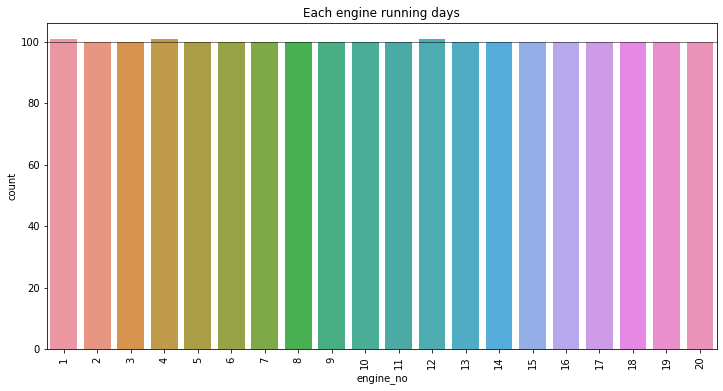

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x='engine_no', data=df)
plt.xticks(rotation='vertical')
plt.axhline(y=100, linewidth = 0.5, color='k')
plt.title("Each engine running days")
plt.show()


**Step 5 - Calculate how many any hours each engine operate & Visualize it !**
- Engine No 17 doesnot operated for whole 100 days.
- Engine No 20 has highest Operating hours followed by Engine no 1
- Engine No 5 has lowest operating hours

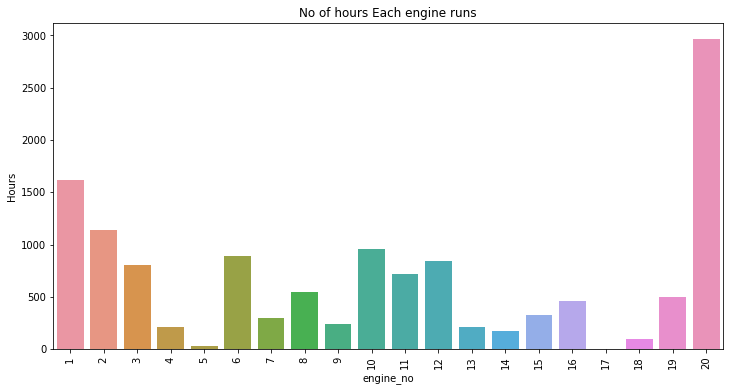

In [8]:
# Split every engine data seperately # 
df_engine_index_1 = df.index[df.engine_id.ne(df.engine_id.shift(1)) == True].tolist()
df_engine_index_2 = df.index[df.engine_id.ne(df.engine_id.shift(-1)) == True].tolist()

# Save it in a Dictionay #
df_engine_operatehours = {} # Only operating cost
column_name = ['oper_hours', 'fuel', 'engine_no']

for k, (i, j) in enumerate(zip(df_engine_index_1,df_engine_index_2)):
    df_engine_operatehours['Engine_' + str(k + 1)] = df.loc[i : j, ['operating_hours', 'fuel_consumption(liter)']].reset_index(drop=True) 
    df_engine_operatehours['Engine_' + str(k + 1)]['Engine_No'] = int(k+1)
    df_engine_operatehours['Engine_' + str(k + 1)].columns = column_name

# Make a list, contains all 20 engine data as a Dataframe # 
df_list = [df_engine_operatehours[i] for i in df_engine_operatehours.keys()]

# Every Engine operating hours calculation # 
list_run_hours = [df_list[i]['oper_hours'].iloc[-1] - df_list[i]['oper_hours'].iloc[0] for i in range(len(df_list))]

# Plot the Operating Hours between 20 engines 
df_run_hours = pd.DataFrame({'Hours' : list_run_hours, 'engine_no' : range(1,21)})
plt.figure(figsize=(12,6))
sns.barplot(x='engine_no', y= 'Hours', data=df_run_hours)
plt.xticks(rotation='vertical')
plt.title("No of hours Each engine runs")
plt.show()

**Step 6 - Visualize each engine Operating hours to check operating hours
increasing trend**
- In Plot, X axis denote NO OF DAYS and Y axis denote OPERATIGN HOURS

**Step 6.1 - Abnormal Identification While plotting so marked RED**
- Engine No 17 - Engine doesn't run.
- Engine No : 18 -  Decrease & Increase.
So normaly if an engine doesn't operate on a particular day the value must be constant from that point, but here the value decreases. 
- Engine No : 19 - Sudden Increase. On Analysis at day no, 79 & 80 values mentioned wrongly


<Figure size 432x288 with 0 Axes>

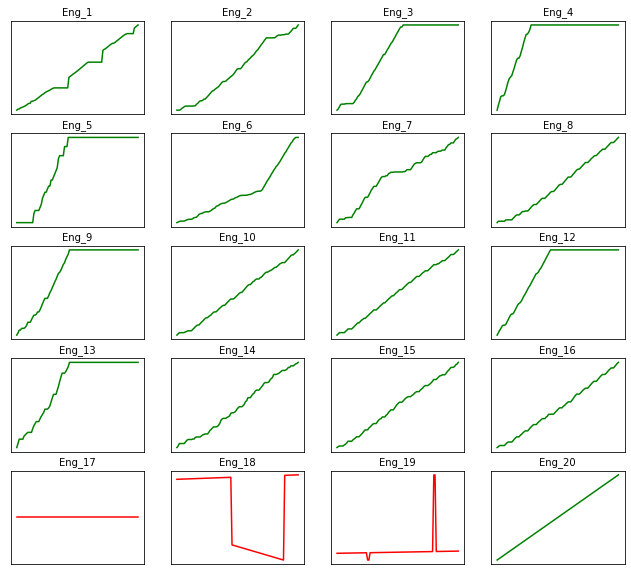

"\n# Plot Eng_18 & Eng_19 graph seperately\nplt.figure(figsize=(10.5,4))\nplt.subplot(1,2,1)\nplt.plot(df_list[17].oper_hours, 'b')\nplt.title('Eng_18', fontsize = 10)\nplt.subplot(1,2,2)\nplt.plot(df_list[18].oper_hours, 'b')\nplt.title('Eng_19', fontsize = 10)\n"

In [9]:
# Plot all 20 engines Operating hours # 
%matplotlib inline
plt.figure()
count = 0
plt.figure(figsize=(11,10))
for v in range(20):
    plt.subplot(5,4, v+1)
    if v == 16 or v == 17 or v == 18:
      plt.plot(df_list[count].oper_hours, 'r')
    else:
      plt.plot(df_list[count].oper_hours, 'g')
    plt.title('Eng_' + str(count+1), fontsize = 10)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    count += 1
plt.show()
print()

**Step 7 - Analyzed and Corrected Engine No 19**

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Eng_19 - After Modification')

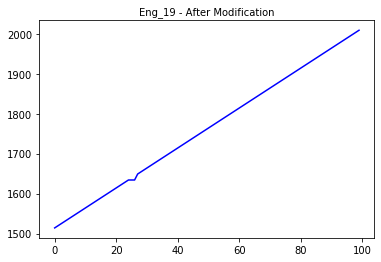

In [10]:
# Change the values in Engine No - 19 to a proper values 
df_list_new = df_list
df_list_new[18] = df_list_new[18].replace(to_replace=0, method='ffill')
prob_ind = [i+1 for i in range(df_list_new[18].shape[0]-1) if df_list_new[18]['oper_hours'][i+1]- df_list_new[18]['oper_hours'][i] > 24]
df_list_new[18]['oper_hours'].iloc[79:81] = df_list_new[18]['oper_hours'].iloc[prob_ind[0]:prob_ind[1]+ 1]/10
# print(len(df_list_new))

# Plot the corrected Engine data #
plt.plot(df_list_new[18].oper_hours, 'b')
plt.title('Eng_19 - After Modification', fontsize = 10)

**Step 8 - Final Check of the Engines Stats**
- Print the engine operating hours in ascending order
- under which operating hours value fall in a bin
- Remove engine No 17 & 18 Finally, Total Engine = 18

In [11]:
# Final Engine Selection #

print('Ascending order engine running hours :')
print(df_run_hours.sort_values(by= ['Hours']).to_string(index=False))
print()

print('Operating hours fall in a bin :')
print(df_run_hours['Hours'].value_counts(bins=4))
print()

df_new = [df_list_new[i]  for i in range(len(df_list_new)) if i not in [16, 17]]
print('Total Engines after preprocessing :', len(df_new))

Ascending order engine running hours :
 Hours  engine_no
     0         17
    28          5
    99         18
   169         14
   208          4
   213         13
   239          9
   296          7
   323         15
   459         16
   495         19
   550          8
   722         11
   804          3
   842         12
   887          6
   961         10
  1135          2
  1614          1
  2970         20

Operating hours fall in a bin :
(-2.971, 742.5]     13
(742.5, 1485.0]      5
(2227.5, 2970.0]     1
(1485.0, 2227.5]     1
Name: Hours, dtype: int64

Total Engines after preprocessing : 18


**Step 8.1 - Final plot w.r.t each engine operating hours after removing Engine 17 & 18**



<Figure size 432x288 with 0 Axes>

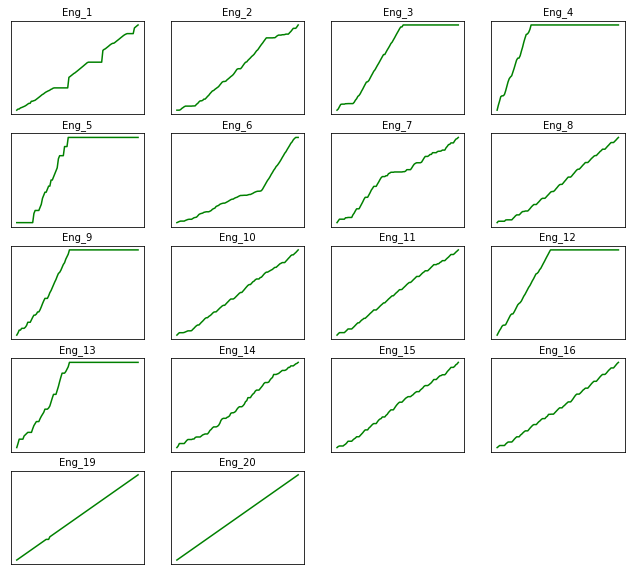

In [12]:
# Final Plot
plt.figure()
count = 0
plt.figure(figsize=(11,10))
for v in range(18):
    plt.subplot(5,4, v+1)
    plt.plot(df_new[count].oper_hours, 'g')
    plt.title('Eng_' + str(df_new[count].engine_no[0]),  fontsize = 10)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    count += 1
plt.show()

**Step 9 - Important Preprocessing functions for training data preparation**
- Difference function to calculate the operating hours difference between two days
- Normalize the data
- Convert the Univariate data into Supervised learning model (Sliding Window Approach), by taking the last 25 days as input and the next 15 days as output
- All the engine data has been converted to supervised learning and saved in a list
- For reference printed Engine No 1 Training data 

In [13]:
# Difference function #
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# Normalize function #
def normalize(dataset):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled_values = scaler.fit_transform(dataset)
  scaled_values = scaled_values.reshape(len(scaled_values), 1)
  return scaled_values, scaler

# Converting into supervised Learning #
def train_data(data, window = 25, pred_steps = 15,dropnan = True):
    X, Y = list(), list()
    for i in range(len(data)):
      # print(i)
      cols, names, y = list(), list(), list()
      for j in range(window, 0, -1):
          cols.append(data[i].shift(j))
          names += [('%s(t-%d)' % (col,  j)) for col in ['oper_hours']] 
      agg = pd.concat(cols, axis=1).dropna().reset_index(drop=True)
      agg.columns = names
      # Target
      for k in range(window, len(data[i]), 1):
          y.append(list((data[i].shift(-k)[:pred_steps])))
      #y = pd.DataFrame(np.array(y), columns = list("abcdefghijklmno"))
      y = pd.DataFrame(np.array(y), columns = ['oper_hours(t+' + str(i+1) + ')'for i in range(pred_steps)])
      
      # Combine
      result = pd.concat([agg, y], axis=1).dropna()
      X.append(result.loc[:, : 'oper_hours(t-1)'])
      Y.append(result.loc[:, 'oper_hours(t+1)' : ])
    return X, Y
  
# Training data prep function #
def final_training_data(df_new, window, pred_steps):
  # Step 1 - Take only Oper hours
  df_step1 = [df_new[i].loc[:,'oper_hours'] for i in range(len(df_new))] # Taken only Oper hours
  # Step 2 - difference calculation
  df_step2 = [(difference(df_step1[i]).values).reshape(len(difference(df_step1[i]).values), 1) for i in range(len(df_step1))]
  # Step 3 - Normalize the values and save the individual scaler in alist
  df_step3, scaler = [], []
  for i in range(len(df_step2)):
    df_norm, norm_scaler = normalize(df_step2[i])
    df_norm = pd.Series(df_norm.reshape(-1))
    df_step3.append(df_norm)
    scaler.append(norm_scaler)
  # Step 4 - Convert to supervised
  X, Y = train_data(df_step3, window, pred_steps)
  return X, Y, scaler,df_step1, df_step2 

# Call & get the training data #
window = int(input('Enter the past days to be considered as training data: '))
pred_steps = int(input('Enter the no of days to be forecasted: '))
X, Y, scaler,df_step1,df_step2 = final_training_data(df_new, window, pred_steps)

#'''
# Print Engine No  data frame after converting the data into supervised learning #

print(f'Taken the last {window} days operating_hours data & predict the next {pred_steps} days')
print()
print('converted every engine Univariate data into supervised Learning')
print()
print('E.g Engine no 1 (X): \n',X[0].head()) 
print()
print('E.g Engine no 1 (Y): \n', Y[0].head())

#'''

Enter the past days to be considered as training data: 25
Enter the no of days to be forecasted: 15
Taken the last 25 days operating_hours data & predict the next 15 days

converted every engine Univariate data into supervised Learning

E.g Engine no 1 (X): 
    oper_hours(t-25)  oper_hours(t-24)  ...  oper_hours(t-2)  oper_hours(t-1)
0         -0.820628         -0.982063  ...        -0.856502        -0.892377
1         -0.982063         -0.820628  ...        -0.892377        -0.892377
2         -0.820628         -0.928251  ...        -0.892377        -0.919283
3         -0.928251         -0.910314  ...        -0.919283        -0.847534
4         -0.910314         -0.910314  ...        -0.847534        -0.910314

[5 rows x 25 columns]

E.g Engine no 1 (Y): 
    oper_hours(t+1)  oper_hours(t+2)  ...  oper_hours(t+14)  oper_hours(t+15)
0        -0.892377        -0.919283  ...         -1.000000         -1.000000
1        -0.919283        -0.847534  ...         -1.000000         -1.000000


**Step 10 - For Model Selection - LSTM Will be the nominal choise for Time series Forecasting**
- More powerful in learning the pattern of the obervations from the start of the sequence
- Recent research papers prove that LSTM produce a best result for Time series sequential Data analysis (e.g Text translations, NLP, Machine Translations etc)

**Step 10.1 - Which models were initiated/used ?**
- Based on user selection the Model and Engine no will be initiated for training
- Statefull LSTM model, Vanilla LSTM(1 Layer), Stacked LSTM Model (2 Layer)
- Model built for only one Engine Univariate data (engine no 1 -18)

**Step 10.2 - Important Note**
- After trying out different hyperparamters, the below hyper params were used for model training. 
- n_batches = no of batches, nb_epochs = no of epochs, n_neurons = no of neurons, relu optimizer,  
- train_test_split = 80 : 20 ration


In [37]:
# Fit statefull LSTM
def fit_lstm(X, Y, engine, test_split, n_batch, nb_epoch, n_neurons):
  X_train, X_test = X[engine].values[0:-test_split], X[engine].values[-test_split:]
  Y_train, Y_test = Y[engine].values[0:-test_split], Y[engine].values[-test_split:]

  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

  model = Sequential()
  model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X_train.shape[1], X_train.shape[2]), stateful=True))
  model.add(Dense(Y_train.shape[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  # fit network
  for i in range(nb_epoch):
    #print(i)
    model.fit(X_train, Y_train, epochs=1, batch_size=n_batch, verbose=0,shuffle=False)
    model.reset_states()
  return model,X_test,Y_test

# Vanilla LSTM  
def fit_Vannila_LSTM(X, Y, engine,test_split, n_batch, nb_epoch, n_neurons_1):
  X_train, X_test = X[engine].values[0:-test_split], X[engine].values[-test_split:]
  Y_train, Y_test = Y[engine].values[0:-test_split], Y[engine].values[-test_split:]
  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
  
  model = Sequential()
  # model.add(LSTM(n_neurons_1,  input_shape=(X_train.shape[1],1)))
  model.add(LSTM(n_neurons_1, activation='relu',  input_shape=(X_train.shape[1],1)))
  model.add(Dense(15))
  model.compile(optimizer='adam', loss='mse')
  H = model.fit(X_train, Y_train, epochs = nb_epoch, batch_size=n_batch, verbose=0, validation_data = (X_test.reshape(X_test.shape[0],X_test.shape[1],1), 
                                                                                                       Y_test), shuffle=False)
  return model,H, X_test, Y_test 

# Stacked LSTM
def fit_Stacked_lstm(X, Y, engine,test_split, n_batch, nb_epoch, n_neurons_1, n_neurons_2):
  X_train, X_test = X[engine].values[0:-test_split], X[engine].values[-test_split:]
  Y_train, Y_test = Y[engine].values[0:-test_split], Y[engine].values[-test_split:]
  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
  
  model = Sequential()
  model.add(LSTM(n_neurons_1, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],1)))
  model.add(LSTM(n_neurons_2, activation='relu'))
  model.add(Dense(15))
  model.compile(optimizer='adam', loss='mse')
  H = model.fit(X_train, Y_train, epochs = nb_epoch, batch_size=n_batch, verbose=0, validation_data = (X_test.reshape(X_test.shape[0],X_test.shape[1],1), 
                                                                                                       Y_test), shuffle=False)
  return model,H, X_test, Y_test

# Vanilla LSTM  
def fit_Vannila_LSTM(X, Y, engine, test_split, n_batch, nb_epoch, n_neurons_1):
  X_train, X_test = X[engine].values[0:-test_split], X[engine].values[-test_split:]
  Y_train, Y_test = Y[engine].values[0:-test_split], Y[engine].values[-test_split:]
  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
  
  model = Sequential()
  # model.add(LSTM(n_neurons_1,  input_shape=(X_train.shape[1],1)))
  model.add(LSTM(n_neurons_1, activation='relu',  input_shape=(X_train.shape[1],1)))
  model.add(Dense(15))
  model.compile(optimizer='adam', loss='mse')
  H = model.fit(X_train, Y_train, epochs = nb_epoch, batch_size=n_batch, verbose=0, validation_data = (X_test.reshape(X_test.shape[0],X_test.shape[1],1), 
                                                                                                       Y_test), shuffle=True)
  return model,H, X_test, Y_test 

def model_selection(): 
  import time
  Eng = int(input('Which Engine you would like to train : \n Select a number between 0 to 17 : '))
  if Eng not in [i for i in range(0, 18)]:
    print('Enter Valid Engine ID')
  else:
    print('Selection OK, Next Step')
  print()
  Mod = input('Which model you would like to run : \n Option A) Statefull LSTM \n Option B) Vanilla LSTM \n Option C) Stacked LSTM \n')
  print()
  train_split = int(input('Select Train data percentage: '))
  test_data = len(X[int(Eng)]) - round(len(X[int(Eng)])*(train_split/100))
  print(test_data)
  start = time.time()
  print()
  print('Training......')
  
  if Mod == 'A':
    # Statefull LSTM model
    model,X_test, Y_test = fit_lstm(X, Y, int(Eng), test_data, 1, 300, 3)
  
  elif Mod == 'B':
    # fit Vannila LSTM
    #model,H, X_test, Y_test = fit_Vannila_LSTM(X, Y, int(Eng),test_data, 8, 300, 3, validation_data = ())
    model,H, X_test, Y_test = fit_Vannila_LSTM(X, Y, int(Eng),test_data, 8, 300, 3)
  
  elif Mod == 'C':
  # fit stacked LSTM
    model,H, X_test, Y_test = fit_Stacked_lstm(X, Y, int(Eng),test_data, 8, 300, 5, 3)

  end = time.time()
  print('Training Completed')
  print('Time Taken {:.2f}s!'.format(end-start))
  
  # plot the model Loss details
  # plt.figure()
  # plt.plot(H.history['loss'])
  # plt.plot(H.history['val_loss'])
  # plt.title('model loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()
 
  return model, X_test, Y_test, Eng

model, X_test, Y_test, engine_no = model_selection()



Which Engine you would like to train : 
 Select a number between 0 to 17 : 6
Selection OK, Next Step

Which model you would like to run : 
 Option A) Statefull LSTM 
 Option B) Vanilla LSTM 
 Option C) Stacked LSTM 
A

Select Train data percentage: 80
12

Training......
Training Completed
Time Taken 579.96s!


**Step 11 - Model Forecasting and RMSE Score calculation**
- Testing Data = 12 (20 %)
 
**Step 11.1 Plot each predicted values in a plot over the actual value plot**



RMSE_Score Values
from day 48 to 72 the Actual VS Prdiction RMSE score =  2.3015656859173466
from day 49 to 73 the Actual VS Prdiction RMSE score =  2.600271085462768
from day 50 to 74 the Actual VS Prdiction RMSE score =  2.6534263909972524
from day 51 to 75 the Actual VS Prdiction RMSE score =  2.829571198274649
from day 52 to 76 the Actual VS Prdiction RMSE score =  2.7261200334740368
from day 53 to 77 the Actual VS Prdiction RMSE score =  2.9356266349695743
from day 54 to 78 the Actual VS Prdiction RMSE score =  2.460449892796526
from day 55 to 79 the Actual VS Prdiction RMSE score =  2.4992899786980636
from day 56 to 80 the Actual VS Prdiction RMSE score =  2.667649443460694
from day 57 to 81 the Actual VS Prdiction RMSE score =  2.7879948350681367
from day 58 to 82 the Actual VS Prdiction RMSE score =  2.8006121437543205
from day 59 to 83 the Actual VS Prdiction RMSE score =  2.824741155415796

R2_Score Values
from day 48 to 72 the Actual VS Prdiction r2 score =  0.8825279877308

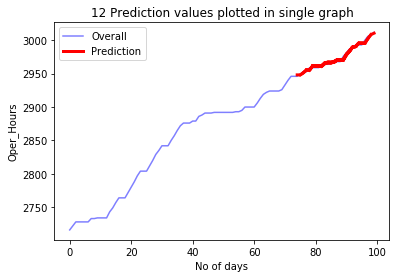

<Figure size 432x288 with 0 Axes>

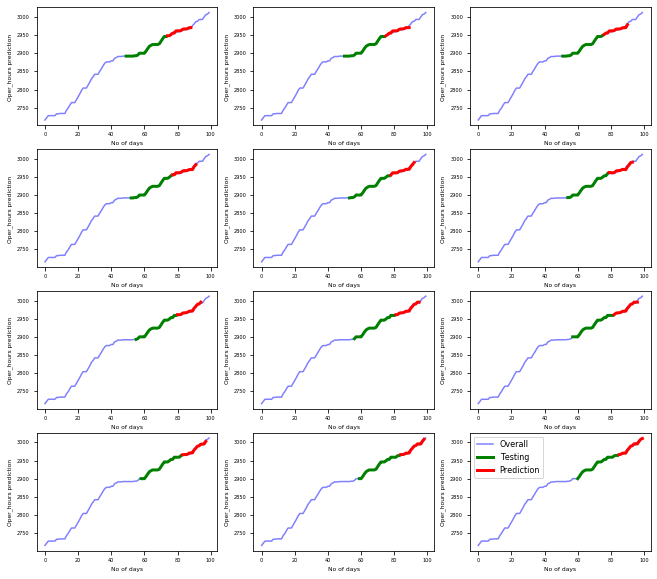

In [67]:
def forecast_RMSE_calculator(model, X_test, Y_test, engine_no, pred_steps, window):
  if len(X_test.shape) == 1:
    X_test = X_test.reshape(1,X_test.shape[0],1)
  else:
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

  # Forecast
  forecasts = model.predict(X_test, batch_size=1)
  final_forecasts = []
  #print('model_forecasts :', len(forecasts))

  # Find indices
  indices = []
  for i in range(len(forecasts)):
    invert = array(forecasts[i]).reshape(1,len(forecasts[i]))
    inv_scale = scaler[engine_no].inverse_transform(invert)
    inv_scale = inv_scale[0, :]
    final_forecasts.append(inv_scale)
    # find index
    index = len(X[engine_no]) - len(X_test) +  i  # len(X_test) or test_split
    index = index + 25
    indices.append(index)
  # print(indices) 
  final_forecasts = np.array(final_forecasts)
  
  # print('Indices :', indices)
  # print('final_forecasts :', final_forecasts)

  # Finding actual difference
  act = np.array([df_step2[engine_no][indices[i] : indices[i]+ pred_steps] for i in range(len(indices))])
  act = act.reshape((X_test.shape[0],pred_steps))
  #print('act :',act)

  # Actual Values in Hours
  original = []
  for i in range(len(indices)):# 12
    temp1 = []
    for j in range(act.shape[1]):# 15
      temp1.append(df_step1[engine_no][indices[i]+j] + act[i][j])
    original.append(temp1)
  original = np.array(original)

  # predicted Value hours
  predict = []
  for i in range(len(indices)):# 12
    temp2 = []
    for j in range(final_forecasts.shape[1]):# 15
      temp2.append(df_step1[engine_no][indices[i]+j] + final_forecasts[i][j])
    predict.append(temp2)
  predict = np.array(predict)

  # print(original)
  # print(predict.shape)

  # RMSE calculation
  print()
  print('RMSE_Score Values')
  for i in range(len(X_test)):
    ACTUAL = original[i]
    FORECAST = predict[i]
    rmse = sqrt(mean_squared_error(ACTUAL, FORECAST))
    print(f'from day {indices[i]-25} to {indices[i]-1} the Actual VS Prdiction RMSE score =  {rmse}')
  
  # R2 calculation :
  print()
  print('R2_Score Values')
  for i in range(len(X_test)):
    ACTUAL = original[i]
    FORECAST = predict[i]
    r2 = r2_score(ACTUAL, FORECAST)
    print(f'from day {indices[i]-window} to {indices[i]-1} the Actual VS Prdiction r2 score =  {r2}')
  
  print()
  plt.figure()
  plt.plot(df_step1[engine_no], 'b', alpha=0.5)
  plt.title(f'{len(X_test)} Prediction values plotted in single graph')
  plt.xlabel('No of days')
  plt.ylabel('Oper_Hours')
  for i in range(len(predict)):
    # x_axis = df_step1[engine][indices[i]+1 : indices[i]+ 1 +15]
    x_axis = range(indices[i]+1, indices[i]+ 1 +15)
    y_axis = predict[i]
    # print(x_axis, y_axis)
    plt.plot(x_axis, y_axis, 'r', linewidth=3)
  plt.legend(['Overall', 'Prediction'], fontsize= 10)
  
  print()  
  plt.figure()
  plt.figure(figsize=(11,10))
  for i in range(len(predict)):
    plt.subplot(4,3, i+1)
    X_axis = range(indices[i]-25 + 1, indices[i]+1)
    Y_axis = df_step1[engine_no].iloc[X_axis[0] : X_axis[-1]+1]

    x_axis = range(indices[i]+1, indices[i]+ 1 +15)
    y_axis = predict[i]
    plt.xlabel('No of days', fontsize=6)
    plt.ylabel('Oper_hours prediction ', fontsize=6)
    plt.ylabel('Oper_hours prediction ', fontsize=6)
    plt.tick_params(axis='both',labelsize=5)
    plt.plot(df_step1[engine_no], 'b', alpha = 0.5)
    plt.plot(X_axis, Y_axis, 'g',linewidth = 3)
    plt.plot(x_axis, y_axis, 'r', linewidth= 3)

    # to remove the x axis label values
    #plt.gca().axes.get_yaxis().set_visible(False)
    #plt.gca().axes.get_xaxis().set_visible(False)
    
  plt.legend(['Overall', 'Testing', 'Prediction'], fontsize=8)
  plt.show()

  return original, predict

Original, Prediction = forecast_RMSE_calculator(model, X_test, Y_test, engine_no, pred_steps = 15, window=25)

**Conclusion**
- The above model and its results is just the first revision work for time series forecasting.
- There is still a room for improvement in the model.
- Even though the above models produce a good accuracy/prediction rate.
- RMSE Score & R2 score metrics has been employed to check the performance.
- As per the above results, Stacked LSTM & Statfull LSTM with 1 Layer Model Produces a good result when comparing with other two models (Detail Analysis has been shown in ppt attached)

